In [3]:
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

# utils

In [4]:
condition = 'mistral'
targets = np.load('predictions/targets_'+condition+'_test.npy')
past_values = np.load('dataset_test/past_values_da.npy')
types = np.load('dataset_test/static_categorical_features.npy')
preds = np.load('predictions/preds_'+condition+'_test.npy')
time= np.load('dataset_test/future_time_features.npy')[:,0]
text = np.load('dataset_test/past_values_text.npy')
context = np.load('dataset_test/contexts.npy')

In [5]:
df=pd.DataFrame(np.array([past_values[:,-1], preds, targets,types[:-1],time[:,0],context]).T, columns=['past', 'pred', 'target','types','time','context'])
df.head()

,past,pred,target,types,time,context
0,3,3,0,Resistant to change,1,Therapist: You okay now kind of taking a look...
1,3,4,0,Resistant to change,3,Therapist: You okay now kind of taking a look ...
2,3,4,3,Resistant to change,5,Therapist: So you remember accomplishing thing...
3,3,3,3,Resistant to change,7,Therapist: You kept people safe. And you had a...
4,3,3,3,Resistant to change,9,"Therapist: When you described it, it almost so..."


In [6]:
df['past'] = df['past'].astype(int)
df['pred'] = df['pred'].astype(int)
df['target'] = df['target'].astype(int)

In [7]:
da_names = ["Sharing personal information or Describe past event",
"Changing unhealthy behavior in the future",
"Sustaining unhealthy behavior in the future",
"Sharing negative feeling or emotion",
"Sharing positive feeling or emotion",
"Understanding or New Perspective",
"Greeting or Closing",
"Backchannel"]
da_names_all = ["Sharing personal information or Describe past event",
"Changing unhealthy behavior in the future",
"Sustaining unhealthy behavior in the future",
"Sharing negative feeling or emotion",
"Sharing positive feeling or emotion",
"Understanding or New Perspective",
"Greeting or Closing",
"Backchannel",
            "Asking for Medical Information",
"Unknown",
"Reflection",
"Ask for Information",
"Invite to Shift Outlook",
"Ask about current Emotions",
"Give Solution",
"Planning with the Patient",
"Experience Normalization and Reassurance",
"Medical Education and Guidance",
"Greeting or Closing_t",
"Backchannel_t",
"Ask for Consent or Validation",
"Progress Acknowledgment and Encouragement",
"Empathic Reaction",
"Unknown"]

In [8]:
class Word2Vec(nn.Module):

    def __init__(self, embedding_size, vocab_size):
        super(Word2Vec, self).__init__()
        self.embeddings_target = nn.Embedding(vocab_size, embedding_size)
        self.embeddings_context = nn.Embedding(vocab_size, embedding_size)
        self.vocab_size = vocab_size

    def forward(self, target_word, context_word, negative_example):
        emb_target = self.embeddings_target(target_word)
        emb_context = self.embeddings_context(context_word)
        emb_product = torch.mul(emb_target, emb_context)
        emb_product = torch.sum(emb_product, dim=1)
        out = torch.sum(F.logsigmoid(emb_product))
        emb_negative = self.embeddings_context(negative_example)
        emb_product = torch.bmm(emb_negative, emb_target.unsqueeze(2))
        emb_product = torch.sum(emb_product, dim=1)
        out += torch.sum(F.logsigmoid(-emb_product))
        return -out

    def get_closest_word(self, batch_word):
        # min distance between batch_word and all words in the embedding

        batch_word = batch_word.unsqueeze(1)

        batch_word = batch_word.repeat(1, 8, 1)
        all_words = torch.arange(8).unsqueeze(0).repeat(batch_word.size(0), 1).to(batch_word.device)
        all_words = self.embeddings_target(all_words)
        distances = torch.norm(batch_word - all_words, dim=-1)

        return torch.argmin(distances, dim=-1)

In [9]:
w2v = Word2Vec(8, 24)
w2v.load_state_dict(torch.load('word2vec.pth'))

<All keys matched successfully>

# Accuracy

In [10]:
# F1 score
def compute_accuracy(preds, target):
    """
    Compute the accuracy of a list of predictions
    """
    preds = torch.tensor(preds)
    target = torch.tensor(target)
    return torch.sum(preds == target).item() / len(preds)


In [11]:
print("Accuracy : ", compute_accuracy(df['pred'], df['target']))

Accuracy :  0.42263056092843326


In [12]:
# F1 score
from sklearn.metrics import f1_score
def compute_f1(df):
    """
    Compute the f1 score of a list of predictions
    """
    return f1_score(df['target'], df['pred'], average='macro')


In [13]:
from bstrap import boostrapping_CI
boostrapping_CI(compute_f1, df, nbr_runs=1000)

{'avg_metric': 0.34763901285623877,
 'metric_ci_lb': 0.3216328925192017,
 'metric_ci_ub': 0.3737302327670764}

In [14]:
# confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
def plot_confusion_matrix(preds, target):
    """
    Plot the confusion matrix of a list of predictions
    """
    cm = confusion_matrix(target, preds)
    # normalize
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(10,7))
    sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=da_names, yticklabels=da_names)
    plt.xlabel('Predicted')
    plt.ylabel('Truth')
    plt.show()

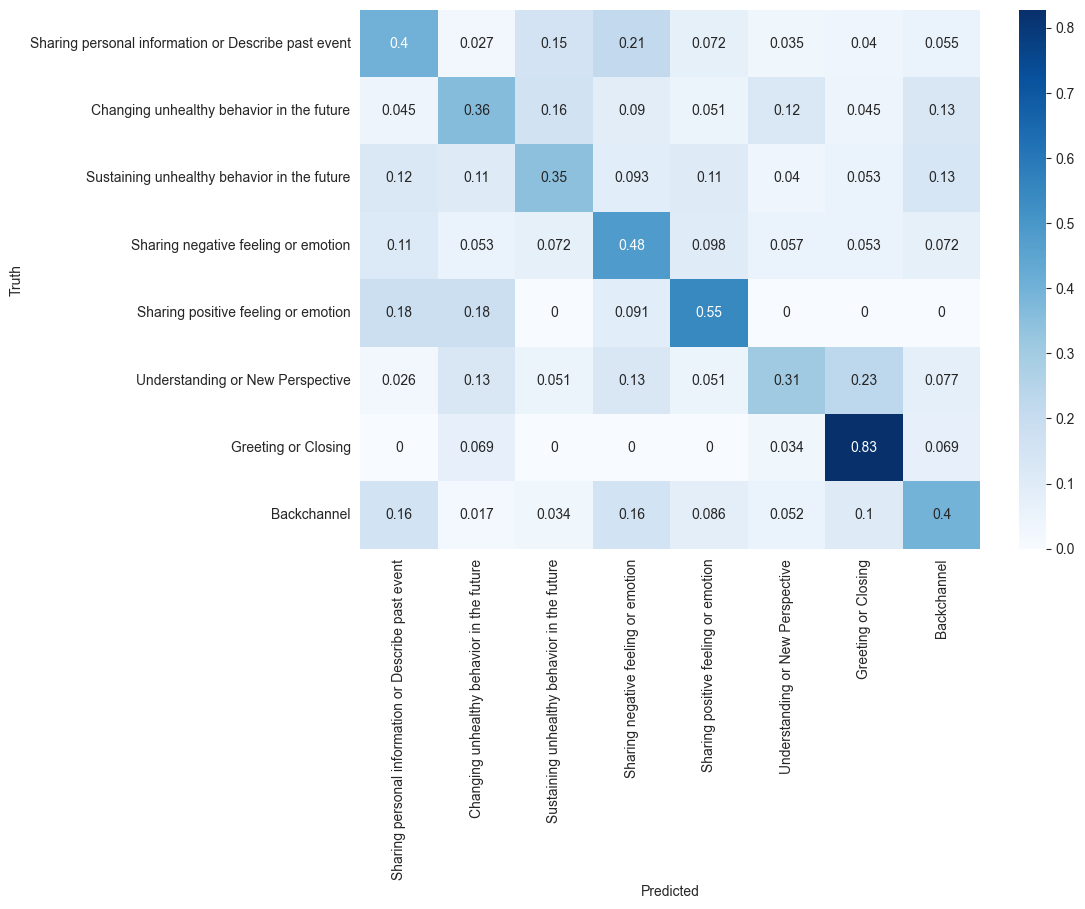

In [15]:
plot_confusion_matrix(df['pred'], df['target'])

# Unexpectedness

In [16]:
def compute_unexpectedness(preds, target, w2v):
    """
    Compute the unexpectedness of a list of predictions
    """
    preds = torch.tensor(preds)
    target = torch.tensor(target)
    preds_emb = w2v.embeddings_target(preds)
    target_emb = w2v.embeddings_target(target)
    # Compute the cosine similarity between the average and the word2vec embeddings
    cos = torch.nn.CosineSimilarity(dim=0)
    sim = cos(preds_emb, target_emb).detach().numpy().item()
    return 1-sim

In [17]:
df['unexpectedness'] = df.apply(lambda x : compute_unexpectedness(x['pred'], x['target'], w2v), axis=1)
df_new = df[df['unexpectedness']>0]

In [18]:
def unexpect(df):
    return df[df['unexpectedness']>0]['unexpectedness'].mean()
boostrapping_CI( unexpect,df_new, 1000)

{'avg_metric': 0.6976396940909114,
 'metric_ci_lb': 0.6657984500058985,
 'metric_ci_ub': 0.7303664011073083}

# Diversity

In [19]:
def compute_diversity(df):
    """
    Compute the diversity of a list of predictions
    """
    d = df['pred'].value_counts()/len(df)

    return (d*d).sum()

In [20]:
boostrapping_CI( compute_diversity,df, 1000)

{'avg_metric': 0.15675271335520727,
 'metric_ci_lb': 0.14985034924744378,
 'metric_ci_ub': 0.1641509751617163}

([0, 1, 2, 3, 4, 5, 6, 7],
 [Text(0, 0, 'Backchannel'),
  Text(1, 0, 'Changing unhealthy behavior in the future'),
  Text(2, 0, 'Greeting or Closing'),
  Text(3, 0, 'Sharing negative feeling or emotion'),
  Text(4, 0, 'Sharing personal information or Describe past event'),
  Text(5, 0, 'Sharing positive feeling or emotion'),
  Text(6, 0, 'Sustaining unhealthy behavior in the future'),
  Text(7, 0, 'Understanding or New Perspective')])

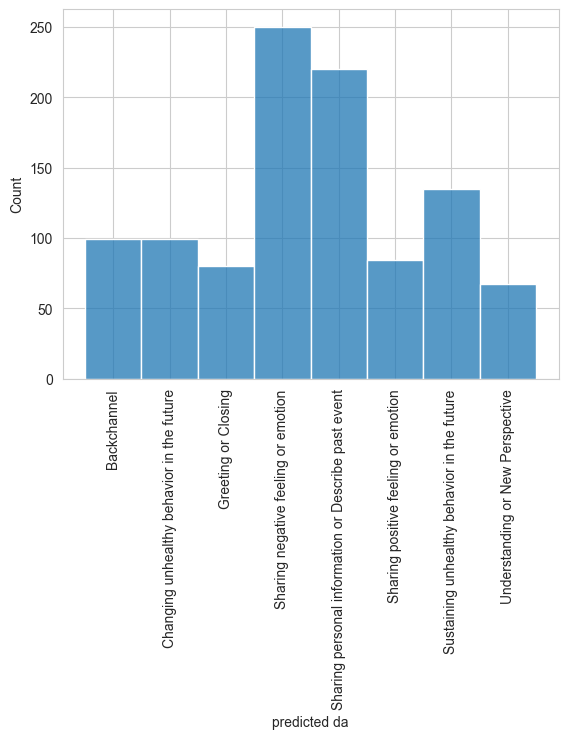

In [21]:
df['predicted da'] = df['pred'].apply(lambda x : da_names[x])
df.sort_values(by='predicted da', inplace=True)
sns.histplot(df,x='predicted da')
plt.xticks(rotation=90)

# Automatic Relevance

In [22]:
rel = pd.read_json('unieval_scores/prediction_'+condition+'_test_scores.json')
rel['relevance'] =(rel['naturalness']+rel['coherence'])/2
df['relevance'] = rel['relevance']
df_new = df[df['unexpectedness']>0]

In [23]:
def compute_relevance(df):
    return df['relevance'].mean()

In [24]:
from bstrap import boostrapping_CI
boostrapping_CI(compute_relevance, df_new, nbr_runs=1000)

{'avg_metric': 0.892575740116576,
 'metric_ci_lb': 0.8843751152451255,
 'metric_ci_ub': 0.9010457061114808}

# Serendipity

In [25]:
df['serendipity'] = df.apply(lambda x : x['relevance'] * x['unexpectedness'], axis=1)
df_new = df[df['unexpectedness']>0]

In [26]:
def compute_serendipity(df):
    return df['serendipity'].mean()

In [27]:
from bstrap import boostrapping_CI
boostrapping_CI(compute_serendipity, df_new, nbr_runs=1000)

{'avg_metric': 0.618353599861049,
 'metric_ci_lb': 0.5900283690024922,
 'metric_ci_ub': 0.644070489286299}